In [1]:
using Pkg; haskey(Pkg.installed(),"Knet") || Pkg.add("Knet")
using Statistics: mean
using Base.Iterators: cycle
using Knet: Knet, AutoGrad, Data, param, param0, mat, RNN, dropout, value, nll, adam, minibatch, progress!, converge, Random

In [2]:
using Knet: TimerOutputs

In [3]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Pkg; for p in ("Knet","Plots"); haskey(Pkg.installed(),p) || Pkg.add(p); end
using Knet: Knet, dir, zeroone, progress, sgd, load, save, gc, Param, KnetArray, gpu, Data, nll, relu, training, dropout # param, param0, xavier
using Statistics: mean
using Base.Iterators: flatten

In [4]:
import LinearAlgebra
using Plots; default(fmt=:png,ls=:auto)

In [5]:
atype = Knet.gpu()>=0 ? Knet.KnetArray : Array

KnetArray

In [6]:
UDEPREL = Dict{String,Int8}(
"root"       => 1,  # root
"acl"        => 2,  # clausal modifier of noun (adjectival clause)
"advcl"      => 3,  # adverbial clause modifier
"advmod"     => 4,  # adverbial modifier
"amod"       => 5,  # adjectival modifier
"appos"      => 6,  # appositional modifier
"aux"        => 7,  # auxiliary
"case"       => 8,  # case marking
"cc"         => 9,  # coordinating conjunction
"ccomp"      => 10, # clausal complement
"clf"        => 11, # classifier
"compound"   => 12, # compound
"conj"       => 13, # conjunct
"cop"        => 14, # copula
"csubj"      => 15, # clausal subject
"dep"        => 16, # unspecified dependency
"det"        => 17, # determiner
"discourse"  => 18, # discourse element
"dislocated" => 19, # dislocated elements
"expl"       => 20, # expletive
"fixed"      => 21, # fixed multiword expression
"flat"       => 22, # flat multiword expression
"goeswith"   => 23, # goes with
"iobj"       => 24, # indirect object
"list"       => 25, # list
"mark"       => 26, # marker
"nmod"       => 27, # nominal modifier
"nsubj"      => 28, # nominal subject
"nummod"     => 29, # numeric modifier
"obj"        => 30, # object
"obl"        => 31, # oblique nominal
"orphan"     => 32, # orphan
"parataxis"  => 33, # parataxis
"punct"      => 34, # punctuation
"reparandum" => 35, # overridden disfluency
"vocative"   => 36, # vocative
"xcomp"      => 37, # open clausal complement
)

Dict{String,Int8} with 37 entries:
  "reparandum" => 35
  "root"       => 1
  "vocative"   => 36
  "csubj"      => 15
  "advmod"     => 4
  "expl"       => 20
  "iobj"       => 24
  "mark"       => 26
  "advcl"      => 3
  "nmod"       => 27
  "parataxis"  => 33
  "orphan"     => 32
  "nsubj"      => 28
  "discourse"  => 18
  "dep"        => 16
  "appos"      => 6
  "ccomp"      => 10
  "conj"       => 13
  "goeswith"   => 23
  "list"       => 25
  "xcomp"      => 37
  "amod"       => 5
  "aux"        => 7
  "acl"        => 2
  "case"       => 8
  ⋮            => ⋮

In [7]:
function load_data2(path)
    xtrain, ytrain = open(path) do f
    xtrain = []
    ytrain = []
    sentence = []
    arcs = []
    count = 1
    for i in enumerate(eachline(f))  
      if i[2] == ""
        push!(xtrain, sentence)
        labels = zeros(count, count)
        push!(ytrain, arcs)
      elseif i[2][1] != '#'
        temp = split(i[2])
        if temp[1] == "1"
            sentence = []
            arcs = []
            push!(sentence, temp[2])
            push!(arcs, parse(Int64, temp[7]))
            count = 1
        else
            push!(sentence, temp[2]) 
            if isnumeric(temp[7][1])
                push!(arcs, parse(Int64, temp[7]))
            else
                push!(arcs, 0)
            end
            count += 1
        end
      end
    end
    xtrain, ytrain
    end
    xtrain, ytrain
end

load_data2 (generic function with 1 method)

In [8]:
function load_data3(path, UDEPREL)
    xtrain, ytrain, deprels = open(path) do f
    xtrain = []
    ytrain = []
    deprels = []
    sentence = []
    temprels = []
    arcs = []
    count = 1
    for i in enumerate(eachline(f))  
      if i[2] == ""
        push!(xtrain, sentence)
        labels = zeros(count, count)
        push!(ytrain, arcs)
        push!(deprels, temprels)
      elseif i[2][1] != '#'
        temp = split(i[2])
        if temp[1] == "1"
            sentence = []
            arcs = []
            temprels = []
            push!(sentence, temp[2])
            push!(arcs, parse(Int64, temp[7]))
            tmp = split(temp[8], ":")
            push!(temprels, get(UDEPREL, lowercase(tmp[1]), 0))
            count = 1
        else
            push!(sentence, temp[2]) 
            tmp = split(temp[8], ":")
            push!(temprels, get(UDEPREL, lowercase(tmp[1]), 0))
            if isnumeric(temp[7][1])
                push!(arcs, parse(Int64, temp[7]))
            else
                push!(arcs, 0)
            end
            count += 1
        end
      end
    end
    xtrain, ytrain, deprels
    end
    xtrain, ytrain, deprels
end

load_data3 (generic function with 1 method)

In [9]:
function load_embed(path)
    wembed, wembedind = open(path) do f
        wembed = Dict()
        wembedind = []
        for i in enumerate(eachline(f))
            line = i[2]
            tokens = split(line)
            key = tokens[1]
            temp = Array{Float32, 1}()
            for token in tokens[2:end]
                tmp = tryparse(Float32, token)
                append!(temp, tmp)
            end
            wembed[key] = i[1]
            push!(wembedind,temp)
        end
        wembed, wembedind
    end
    wembed, wembedind
end

load_embed (generic function with 1 method)

In [10]:
function take_input(sentence)
    x = []
    words = split(sentence)
    for word in words
        if occursin("'", word)
            if occursin("n't", word)
                push!(x, word[1:end-3])
                push!(x, word[end-2:end])
            else
                temp = split(word, "'")
                push!(x, temp[1])
                push!(x, "'" * temp[2])
            end
            elseif (word[end] >= 'z' || word[end] <= 'A') && !isnumeric(word[end])
            push!(x, word[1:end-1])
            push!(x, word[end:end])
        else
            push!(x, word)
        end    
    end
    x
end

take_input (generic function with 1 method)

In [11]:
rootind = 399999

399999

In [12]:
function getind(word; max=400000, root=false)
    abc = get(wembed,lowercase(word),-1)
    if root == true
        return max-1
    elseif (abc >= 0)
        return abc
    else
        return max
    end
end

getind (generic function with 1 method)

In [13]:
data2 = load_data2("en_ewt-ud-train.conllu")

(Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced", "that", "they", "had", "busted", "up", "3", "terrorist", "cells", "operating", "in", "Baghdad", "."], Any["Two", "of", "them", "were", "being", "run", "by", "2", "officials", "of", "the", "Ministry", "of", "the", "Interior", "!"], Any["The", "MoI", "in", "Iraq", "is", "equivalent", "to", "the", "US", "FBI"  …  "members", "of", "the", "Weathermen", "bombers", "back", "in", "the", "1960s", "."], Any["The", "third", "was", "being", "run", "by", "the", "head", "of", "an", "investment", "firm", "."], Any["You", "wonder", "if", "he", "was", "manipulating", "the", "market", "with", "his", "bombing", "targets", "."], Any["The", "c

In [14]:
rdat1 = load_data3("en_ewt-ud-train.conllu",UDEPREL)

(Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced", "that", "they", "had", "busted", "up", "3", "terrorist", "cells", "operating", "in", "Baghdad", "."], Any["Two", "of", "them", "were", "being", "run", "by", "2", "officials", "of", "the", "Ministry", "of", "the", "Interior", "!"], Any["The", "MoI", "in", "Iraq", "is", "equivalent", "to", "the", "US", "FBI"  …  "members", "of", "the", "Weathermen", "bombers", "back", "in", "the", "1960s", "."], Any["The", "third", "was", "being", "run", "by", "the", "head", "of", "an", "investment", "firm", "."], Any["You", "wonder", "if", "he", "was", "manipulating", "the", "market", "with", "his", "bombing", "targets", "."], Any["The", "c

In [15]:
rdat1[1]

12543-element Array{Any,1}:
 Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."]                                 
 Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"]                                                       
 Any["DPA", ":", "Iraqi", "authorities", "announced", "that", "they", "had", "busted", "up", "3", "terrorist", "cells", "operating", "in", "Baghdad", "."]                                             
 Any["Two", "of", "them", "were", "being", "run", "by", "2", "officials", "of", "the", "Ministry", "of", "the", "Interior", "!"]                                                                       
 Any["The", "MoI", "in", "Iraq", "is", "equivalent", "to", "the", "US", "FBI"  …  "members", "of", "the", "Weathermen", "bombers", "back", "in", "the", "1960s", "."]       

In [16]:
@doc zip

```
zip(iters...)
```

Run multiple iterators at the same time, until any of them is exhausted. The value type of the `zip` iterator is a tuple of values of its subiterators.

Note: `zip` orders the calls to its subiterators in such a way that stateful iterators will not advance when another iterator finishes in the current iteration.

# Examples

```jldoctest
julia> a = 1:5
1:5

julia> b = ["e","d","b","c","a"]
5-element Array{String,1}:
 "e"
 "d"
 "b"
 "c"
 "a"

julia> c = zip(a,b)
Base.Iterators.Zip{Tuple{UnitRange{Int64},Array{String,1}}}((1:5, ["e", "d", "b", "c", "a"]))

julia> length(c)
5

julia> first(c)
(1, "e")
```


In [17]:
data22 = zip((reshape(x,1,1,length(x)) for x in data2[1]),data2[2])

Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##10#11"))},Array{Any,1}}}((Base.Generator{Array{Any,1},getfield(Main, Symbol("##10#11"))}(getfield(Main, Symbol("##10#11"))(), Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced", "that", "they", "had", "busted", "up", "3", "terrorist", "cells", "operating", "in", "Baghdad", "."], Any["Two", "of", "them", "were", "being", "run", "by", "2", "officials", "of", "the", "Ministry", "of", "the", "Interior", "!"], Any["The", "MoI", "in", "Iraq", "is", "equivalent", "to", "the", "US", "FBI"  …  "members", "of", "the", "Weathermen", "bombers", "back", "in", "the", "1960s", "."], Any["The", "third", "was", "be

In [18]:
rdat1[

LoadError: syntax: incomplete: premature end of input

In [19]:
data22c = collect(data22)

12543-element Array{Tuple{Array{Any,3},Array{Any,1}},1}:
 (["Al"]

["-"]

["Zaman"]

...

["Syrian"]

["border"]

["."], [0, 1, 1, 1, 6, 7, 1, 7, 8, 8  …  21, 18, 23, 21, 21, 28, 28, 28, 21, 1])                 
 (["["]

["This"]

["killing"]

...

["come"]

["."]

["]"], [10, 3, 10, 7, 7, 7, 3, 10, 10, 0, 10, 10, 14, 10, 16, 14, 10, 10])                          
 (["DPA"]

[":"]

["Iraqi"]

...

["in"]

["Baghdad"]

["."], [0, 1, 4, 5, 1, 9, 9, 9, 5, 9, 13, 13, 9, 13, 16, 14, 1])                                   
 (["Two"]

["of"]

["them"]

...

["the"]

["Interior"]

["!"], [6, 3, 1, 6, 6, 0, 9, 9, 6, 12, 12, 9, 15, 15, 12, 6])                                    
 (["The"]

["MoI"]

["in"]

...

["the"]

["1960s"]

["."], [2, 6, 4, 2, 6, 0, 10, 10, 10, 6  …  22, 31, 31, 31, 27, 35, 35, 35, 22, 6])                  
 (["The"]

["third"]

["was"]

...

["investment"]

["firm"]

["."], [2, 5, 5, 5, 0, 8, 8, 5, 12, 12, 12, 8, 5])                                          
 (["You"]

["

In [20]:
data4 = ((reshape(cat(rootind,map(getind,x), dims=3),1,length(x)+1),y) for (x,y) in data22)

Base.Generator{Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##10#11"))},Array{Any,1}}},getfield(Main, Symbol("##12#13"))}(getfield(Main, Symbol("##12#13"))(), Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##10#11"))},Array{Any,1}}}((Base.Generator{Array{Any,1},getfield(Main, Symbol("##10#11"))}(getfield(Main, Symbol("##10#11"))(), Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced", "that", "they", "had", "busted", "up", "3", "terrorist", "cells", "operating", "in", "Baghdad", "."], Any["Two", "of", "them", "were", "being", "run", "by", "2", "officials", "of", "the", "Ministry", "of", "the", "Interior", "!"], Any["T

In [21]:
wembed, wembedind = load_embed("glove.6B.50d.txt")

(Dict{Any,Any}("newdigate"=>164100,"daufuskie"=>254784,"single-arm"=>192007,"titration"=>117879,"qajar"=>66399,"pinheiro"=>38763,"hospitalet"=>282158,"kennedale"=>223560,"tetracyclic"=>353804,"moher"=>167242…), Any[Float32[0.418, 0.24968, -0.41242, 0.1217, 0.34527, -0.044457, -0.49688, -0.17862, -0.00066023, -0.6566  …  -0.29871, -0.15749, -0.34758, -0.045637, -0.44251, 0.18785, 0.0027849, -0.18411, -0.11514, -0.78581], Float32[0.013441, 0.23682, -0.16899, 0.40951, 0.63812, 0.47709, -0.42852, -0.55641, -0.364, -0.23938  …  -0.080262, 0.63003, 0.32111, -0.46765, 0.22786, 0.36034, -0.37818, -0.56657, 0.044691, 0.30392], Float32[0.15164, 0.30177, -0.16763, 0.17684, 0.31719, 0.33973, -0.43478, -0.31086, -0.44999, -0.29486  …  -6.3681e-5, 0.068987, 0.087939, -0.10285, -0.13931, 0.22314, -0.080803, -0.35652, 0.016413, 0.10216], Float32[0.70853, 0.57088, -0.4716, 0.18048, 0.54449, 0.72603, 0.18157, -0.52393, 0.10381, -0.17566  …  -0.34727, 0.28483, 0.075693, -0.062178, -0.38988, 0.22902, -0.2

In [22]:
const timo = Knet.TimerOutput()

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      929ms / 0.00%            133MiB / 0.00%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 ──────────────────────────────────────────────────────────────────

In [23]:
wembedmat = zeros(Float32,length(wembedind[1]), length(wembedind))
for i=1:length(wembedind)
    wembedmat[:,i] = convert(Array{Float32,1},wembedind[i])
end

In [24]:
data4_1 = ((x,y .+ 1) for (x,y) in data4)

Base.Generator{Base.Generator{Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##10#11"))},Array{Any,1}}},getfield(Main, Symbol("##12#13"))},getfield(Main, Symbol("##14#15"))}(getfield(Main, Symbol("##14#15"))(), Base.Generator{Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##10#11"))},Array{Any,1}}},getfield(Main, Symbol("##12#13"))}(getfield(Main, Symbol("##12#13"))(), Base.Iterators.Zip{Tuple{Base.Generator{Array{Any,1},getfield(Main, Symbol("##10#11"))},Array{Any,1}}}((Base.Generator{Array{Any,1},getfield(Main, Symbol("##10#11"))}(getfield(Main, Symbol("##10#11"))(), Any[Any["Al", "-", "Zaman", ":", "American", "forces", "killed", "Shaikh", "Abdullah", "al"  …  "the", "town", "of", "Qaim", ",", "near", "the", "Syrian", "border", "."], Any["[", "This", "killing", "of", "a", "respected", "cleric", "will", "be", "causing", "us", "trouble", "for", "years", "to", "come", ".", "]"], Any["DPA", ":", "Iraqi", "authorities", "announced

In [25]:
data4c = collect(data4_1)

12543-element Array{Tuple{Array{Int64,2},Array{Int64,1}},1}:
 ([399999 319 … 719 3], [1, 2, 2, 2, 7, 8, 2, 8, 9, 9  …  22, 19, 24, 22, 22, 29, 29, 29, 22, 2])    
 ([399999 2824 … 3 5281], [11, 4, 11, 8, 8, 8, 4, 11, 11, 1, 11, 11, 15, 11, 17, 15, 11, 11])        
 ([399999 47065 … 1236 3], [1, 2, 5, 6, 2, 10, 10, 10, 6, 10, 14, 14, 10, 14, 17, 15, 2])            
 ([399999 56 … 1793 806], [7, 4, 2, 7, 7, 1, 10, 10, 7, 13, 13, 10, 16, 16, 13, 7])                  
 ([399999 1 … 2990 3], [3, 7, 5, 3, 7, 1, 11, 11, 11, 7  …  23, 32, 32, 32, 28, 36, 36, 36, 23, 7])  
 ([399999 1 … 1002 3], [3, 6, 6, 6, 1, 9, 9, 6, 13, 13, 13, 9, 6])                                   
 ([399999 82 … 2667 3], [3, 1, 7, 7, 7, 3, 9, 7, 13, 13, 13, 7, 3])                                  
 ([399999 1 … 352 3], [3, 5, 5, 1, 13, 13, 13, 12, 12, 12, 8, 5, 16, 16, 13, 5])                     
 ([399999 377 … 6329 3], [7, 4, 7, 7, 7, 22, 9, 7, 9, 12  …  28, 24, 30, 28, 33, 33, 30, 35, 22, 22])
 ([399999 21 … 1577 3

In [26]:
lents(datdat) = map(x->length(x[1]), datdat)

lents (generic function with 1 method)

In [27]:
function minib(data4c,batchsize)
    datdat = sort(data4c, by=x->length(x[1]), rev=true)
    lentsdatdat = lents(datdat)
    uniqdat = unique(lentsdatdat)
    lennnum = [(i,count(x->x==i,lentsdatdat),j) for (j,i) in enumerate(uniqdat)]
    i=1
    j=0
    k=0
    batdat = []
    for (a,b,c) in lennnum
        bb = b
        j += b
        j = i+b
        k=j
        while bb >= batchsize
            j =i+batchsize-1
            
            push!(batdat, (cat([x[1] for x in datdat[i:j]]...,dims=1), cat([x[2] for x in datdat[i:j]]...,dims=2)))
            i=j+1
            bb -= batchsize
        end
        i += bb
    end
    batdat
end

minib (generic function with 1 method)

In [28]:
datmb2 = minib(data4c,25)

470-element Array{Any,1}:
 ([399999 201 … 425 3; 399999 1 … 3 9; … ; 399999 42 … 4353 3; 399999 50 … 28947 806], [10 3 … 5 4; 10 6 … 5 4; … ; 49 10 … 48 50; 18 10 … 5 9])         
 ([399999 42 … 379 3; 399999 20 … 7877 6939; … ; 399999 84 … 611 3; 399999 42 … 111 3], [3 4 … 4 4; 1 4 … 4 4; … ; 46 46 … 44 45; 3 9 … 18 4])           
 ([399999 9 … 963 3; 399999 201 … 25 3; … ; 399999 82 … 102 806; 399999 68 … 490 3], [41 4 … 3 4; 4 4 … 1 4; … ; 41 36 … 42 44; 41 11 … 3 4])            
 ([399999 1319 … 3398 3; 399999 35 … 1167 3; … ; 399999 1 … 22 3; 399999 2773 … 11602 806], [24 24 … 3 6; 4 6 … 6 6; … ; 41 42 … 40 42; 24 10 … 6 6])    
 ([399999 38 … 1323 3; 399999 2726 … 4520 3; … ; 399999 201 … 5342 3; 399999 1 … 547 3], [4 18 … 7 3; 4 7 … 7 31; … ; 40 38 … 35 41; 4 18 … 17 31])      
 ([399999 19 … 10556 3; 399999 49 … 6479 3; … ; 399999 42 … 3125 806; 399999 1 … 2889 3], [5 11 … 6 4; 5 7 … 6 4; … ; 38 40 … 6 40; 5 11 … 42 5])        
 ([399999 109 … 719 3; 399999 133 … 7957 3; … ; 39

In [29]:
wembedmatKN = convert(KnetArray{Float32,2}, wembedmat)

50×400000 KnetArray{Float32,2}:
  0.418        0.013441  …  -0.51181   -0.75898    0.072617
  0.24968      0.23682       0.058706  -0.47426   -0.51393 
 -0.41242     -0.16899       1.0913     0.4737     0.4728  
  0.1217       0.40951      -0.55163    0.7725    -0.52202 
  0.34527      0.63812      -0.10249   -0.78064   -0.35534 
 -0.044457     0.47709   …  -0.1265     0.23233    0.34629 
 -0.49688     -0.42852       0.99503    0.046114   0.23211 
 -0.17862     -0.55641       0.079711   0.84014    0.23096 
 -0.00066023  -0.364        -0.16246    0.24371    0.26694 
 -0.6566      -0.23938       0.56488    0.022978   0.41028 
  0.27843      0.13001   …  -0.63306    0.53964    0.28031 
 -0.14767     -0.063734     -0.48592   -0.36101    0.14107 
 -0.55677     -0.39575       0.76247    0.94198   -0.30212 
  ⋮                      ⋱                                 
  0.012041     0.70358      -0.18204    0.035413  -0.83629 
 -0.054223     0.44858       0.041465   0.58834   -0.24698 
 -0.2987

In [30]:
datmb2[1][2]

52×25 Array{Int64,2}:
 10   3  39   6   4   3   5   7  …  16   1   1   4   4   9   5   4
 10   6   7   6   4   1   5   4      4   2   4   4   4   2   5   4
  7   3   7   6  12   6   5   7     16   6   2  16   1   5   5   9
  6   6   7   6  12   6  21   4      4   6   7  16   4   2   1   6
  7  10   7  30  10   3  21   7      7   2   7   9   4   9   7   4
 10   6   2   6  10   8  10   8  …   4   8   4   9   8   8   5   9
 10   6   7  11   7   3  10   1      9   2  10   9   6   9   9   9
 10  10  15  10  10   3  10  10     16  10  10  16   6   1   7   1
 18   1  15  11   5  12  21   8     16   2   2  12  12  24  11  12
 18  13  15   7  12  12  21  14     16  12  14  12  12  24   9  12
 13  13  15  13   1  14  14  14  …  16  10  13   9   4  13  13   9
 18  10  14  11  14  14  14  14     12  15  14  16  17  24   9  17
 17  10  15  30  12   3  21  10     16  15  10  15  17  15  15  17
  ⋮                   ⋮          ⋱               ⋮                
 43  43  43  40  41  47  43  43  …  46  

In [31]:
#datmb3 = [(x,y') for (x,y) in datmb2]

In [32]:
struct MyData1 end
struct EmbMatT end
struct EmbMatPar end

In [33]:
struct Embed; w; end

Embed(vocab::Int,embed::Int)=Embed(param(embed,vocab))
Embed(wmat, ::EmbMatT) = Embed(wmat)
Embed(wmat, aType, ::EmbMatPar) = Embed(param(wembedmat, atype = aType))
Embed(wmat, ::EmbMatPar) = Embed(param(wembedmat))

(e::Embed)(x) = e.w[:,x]  # (B,T)->(X,B,T)->rnn->(H,B,T)

In [34]:
struct Dense; w; b; f; end
Dense(i::Int,o::Int,f=identity) = Dense(param(o,i), param0(o), f)
(d::Dense)(x) = d.f.(d.w * mat(x,dims=1) .+ d.b)

In [35]:
struct Linear; w; b; end

Linear(input::Int, output::Int)=Linear(param(output,input), param0(output))

(l::Linear)(x) = l.w * mat(x,dims=1) .+ l.b  # (H,B,T)->(H,B*T)->(V,B*T)
(l::Linear)(x,y)= quadl(l(x),y)[1]

In [36]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)
(c::Chain)(d,a,b) = mean(c(x,y) for (x,y) in d)
(c::Chain)(d, ::MyData1) = mean(c(x,y) for (x,y) in d)

In [37]:
MLP(i::Int, h::Int, o::Int) = Chain(Dense(i,h, Knet.relu), Dense(h,o,Knet.relu))

MLP (generic function with 1 method)

In [38]:
function batchmult_old(w,x;dim=3)
    xb = ndims(x)>=3
    wb = ndims(w)>=3
    if(wb && xb)
        return cat(collect([w[:,:,i]*x[:,:,i] for i in 1:size(x,dim)])..., dims=dim)
    elseif(wb)
        return cat(collect([w[:,:,i]*x for i in 1:size(x,dim)])..., dims=dim)
    elseif(xb)
        return cat(collect([w*x[:,:,i] for i in 1:size(x,dim)])..., dims=dim)
    else
        return wb*xb
    end
end

batchmult_old (generic function with 1 method)

In [39]:
function batchmult(w,x;dim=3)
    xb = ndims(x)>=3
    wb = ndims(w)>=3
    if(wb && xb)
        return reshape(vcat(collect([w[:,:,i]*x[:,:,i] for i in 1:size(x,dim)])...), size(w,1), size(x,2), :)
    elseif(wb)
        return reshape(vcat(collect([w[:,:,i]*x for i in 1:size(x,dim)])...), size(w,1), size(x,2), :)
    elseif(xb)
        return reshape(vcat(collect([w*x[:,:,i] for i in 1:size(x,dim)])...), size(w,1), size(x,2), :)
    else
        return wb*xb
    end
end

batchmult (generic function with 1 method)

In [40]:
function batchmult_wew(w,x)
    return reshape(hcat(collect([w[:,i,:]*x[:,i,:] for i in 1:size(x,2)])...), size(w,1), size(x,3), :)
end

batchmult_wew (generic function with 1 method)

In [41]:
function batchmult_new(w,x)
    A = KnetArray{Float32,3}(zeros(size(w,1),size(x,2),size(x,3)))
    for i= 1:size(x,3)
        A[:,:,i] = w[:,:,i]*x[:,:,i]
    end
    A
end

batchmult_new (generic function with 1 method)

In [42]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    tts = size(x,3)
    bbs = size(x,2)
    Knet.@timeit timo "mlphead" archead = bi.mlphead(x)
    Knet.@timeit timo "mlpdep" arcdep = bi.mlpdep(x[:,:,2:end])
    hms = size(archead,1)
    archeadt = archead'
    HW = reshape(archeadt * bi.w , tts, bbs, hms) # t+bh
    #HW1 = reshape(HW,tts,bbs*hms) #t+ bh
    #HW1tr = reshape(HW1', bbs,hms*tts) # b ht+
    #HW1trtr = reshape(HW1tr', hms,tts,bbs) # ht+b
    HW1 = reshape(HW,tts*bbs,hms) #t+b h
    HW1tr = reshape(HW1', hms,tts,bbs) # ht+b
    #HW1trtr = reshape(HW1tr', hms,tts,bbs) # ht+b
    
    Hb = reshape(archeadt * bi.b,bbs,tts)
    Hbt = Hb'
    Hbtr = reshape(Hbt, 1, tts , bbs)
    arcdepr = reshape(arcdep, hms, bbs, tts-1) #hbt
    arcdepr1 = reshape(arcdepr, hms*bbs,(tts-1)) #hb t
    arcdepr1tr = reshape(arcdepr1',(tts-1),hms,bbs)#t hb
    #arcdepr1 = reshape(arcdepr, hms, bbs*(tts-1)) #h bt
    #arcdepr1tr = reshape(arcdepr1', bbs,(tts-1)*hms)#b th
    #arcdepr1trtr = reshape(arcdepr1tr', tts-1,hms,bbs)#thb
    HWH = Knet.bmm(arcdepr1tr,HW1tr)
    #print(size(Hb))
    #HWHtr = reshape(HWH', tts, tts-1 , bbs)
    #print(size(HW[:,1,:]))
    #clct1 = collect([HW[:,i,:]*arcdepr[:,i,:] for i in 1:bbs])
    #clct1 = collect([view(HW,:,:,i)*view(arcdepr,:,:,1) for i in 1:bbs])
    #HWH = hcat(clct1...)
    #HWH = batchmult_wew(HW,arcdepr)
    #HWHr = reshape(HWH, tts,tts-1,bbs)
    S = HWH .+ Hbtr
    Sr = reshape(S, tts-1,tts*bbs)
    Srtr = reshape(Sr', tts,bbs,tts-1)
    return Srtr
end

In [43]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    tts = size(x,3)
    bbs = size(x,2)
    Knet.@timeit timo "mlphead" archead = bi.mlphead(x)
    Knet.@timeit timo "mlpdep" arcdep = bi.mlpdep(x[:,:,2:end])
    hms = size(archead,1)
    archeadr = reshape(archead, hms, bbs, tts)
    #archeadr2 = reshape(archead, hms, bbs, tts)
    #KnetArray(permutedims(Array(archeadr),[3, 1, 2]))
    Knet.@timeit timo "perdim1" archeadp = KnetArray(permutedims(Array(archeadr),[3, 1, 2]))
    Knet.@timeit timo "perdim2" archeadpp = KnetArray(permutedims(Array(archeadr),[3, 2, 1]))
    archeadppr = reshape(archeadpp, bbs*tts, hms)
    Knet.@timeit timo "WH" WH = bi.w * arcdep
    WHr = reshape(WH, size(WH,1), bbs, tts-1)
    #KnetArray(permutedims(Array(WHr),[1, 3, 2]))
    Knet.@timeit timo "perdim3" WHp = KnetArray(permutedims(Array(WHr),[1, 3, 2]))
    Knet.@timeit timo "HWH(bmm)" HWH = Knet.bmm(archeadp, WHp)
    Hb = archeadppr * bi.b 
    Hbr = reshape(Hb, tts, 1 , bbs)
    S = HWH .+ Hbr
end

In [44]:
a = [3,1,2]

3-element Array{Int64,1}:
 3
 1
 2

In [45]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    tts = size(x,3)
    bbs = size(x,2)
    Knet.@timeit timo "mlphead" archead = bi.mlphead(x)
    Knet.@timeit timo "mlpdep" arcdep = bi.mlpdep(x[:,:,2:end])
    hms = size(archead,1)
    Knet.@timeit timo "perdim1" archeadp = KnetArray(permutedims(Array(reshape(archead, hms, bbs, tts)), [3, 1, 2]))
    Knet.@timeit timo "perdim2" archeadpp = KnetArray(permutedims(Array(reshape(archead, hms, bbs, tts)), [3, 2, 1]))
    archeadppr = reshape(archeadpp, bbs*tts, hms)
    Knet.@timeit timo "WH" WH = bi.w * arcdep
    Knet.@timeit timo "perdim3" WHp = KnetArray(permutedims(Array(reshape(WH, size(WH,1), bbs, tts-1)), [1,3,2]))
    Knet.@timeit timo "HWH(bmm)" HWH = Knet.bmm(archeadp, WHp)
    Hb = archeadppr * bi.b 
    Hbr = reshape(Hb, tts, 1 , bbs)
    S = HWH .+ Hbr
end

In [46]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    tts = size(x,3)
    bbs = size(x,2)
    Knet.@timeit timo "mlphead" archead = bi.mlphead(x)
    Knet.@timeit timo "mlpdep" arcdep = bi.mlpdep(x[:,:,2:end])
    hms = size(archead,1)
    Knet.@timeit timo "perdim1" archeadp = reshape(archead, hms* bbs, tts)' #t x hb
    Knet.@timeit timo "perdim2" archeadpp = permutedims(reshape(archead, hms, bbs, tts), [3, 2, 1])
    archeadppr = reshape(archeadpp, bbs*tts, hms)
    Knet.@timeit timo "WH" WH = bi.w * arcdep
    Knet.@timeit timo "perdim3" WHp = permutedims(reshape(WH, size(WH,1), bbs, tts-1), [1,3,2])
    Knet.@timeit timo "HWH(bmm)" HWH = Knet.bmm(archeadp, WHp)
    Hb = archeadppr * bi.b 
    Hbr = reshape(Hb, tts, 1 , bbs)
    S = HWH .+ Hbr
end

In [47]:
fModel(tembed::Int, rnnh::Int, mlp1h::Int, mlp1o::Int; o...) = 
    Chain(RNN(tembed, rnnh; bidirectional=true, rnnType = :lstm,o...), Biaff(2*rnnh,mlp1h,mlp1o))

fModel (generic function with 1 method)

In [48]:
fModel2(wmat, tembed::Int, rnnh::Int, mlp1h::Int, mlp1o::Int; o...) = 
    Chain(Embed(wmat, EmbMatT()), RNN(tembed, rnnh; bidirectional=true, rnnType = :lstm,o...), Biaff(2*rnnh,mlp1h,mlp1o))

fModel2 (generic function with 1 method)

In [49]:
fModel3(wmat, tembed::Int, rnnh::Int, mlp1h::Int, mlp1o::Int; o...) = 
    Chain(Embed(wmat, KnetArray, EmbMatPar()), RNN(tembed, rnnh; bidirectional=true, rnnType = :lstm,dropout=0.3, o...), Biaff(2*rnnh,mlp1h,mlp1o))

fModel3 (generic function with 1 method)

In [50]:
datmb2sh = Knet.shuffle(datmb2)
#datmb3sh = Knet.shuffle(datmb3)

470-element Array{Any,1}:
 ([399999 42 … 284 3; 399999 1 … 1573 3; … ; 399999 153615 … 607 3; 399999 831 … 7085 1485], [4 3 … 8 1; 4 5 … 8 2; … ; 15 8 … 13 4; 4 5 … 8 19])     
 ([399999 40 … 833 3; 399999 40 … 1655 3; … ; 399999 5 … 49 3; 399999 24 … 3 25], [5 3 … 3 8; 5 1 … 7 6; … ; 13 17 … 15 8; 5 3 … 7 8])                
 ([399999 183070 … 104 3; 399999 26 … 189 9; … ; 399999 159 … 9351 3; 399999 13698 … 3 13698], [1 5 … 3 3; 2 5 … 15 16; … ; 18 7 … 15 16; 2 7 … 15 3])
 ([399999 8 … 86 3; 399999 2539 … 20369 3; … ; 399999 54 … 11592 3; 399999 121 … 2040 189], [4 4 … 4 3; 4 2 … 4 1; … ; 11 10 … 13 11; 4 4 … 4 3])     
 ([399999 85 … 13 3; 399999 24093 … 5857 3; … ; 399999 1872 … 4051 3; 399999 3833 … 1156 3], [7 8 … 1 3; 7 4 … 2 1; … ; 7 1 … 6 7; 7 8 … 2 3])        
 ([399999 30 … 3 9; 399999 64 … 5536 3; … ; 399999 1887 … 18815 3; 399999 423 … 2779 3], [3 3 … 1 1; 16 1 … 2 2; … ; 16 14 … 16 16; 16 3 … 2 2])      
 ([399999 42 … 17203 3; 399999 11 … 547 189; … ; 399999 42 … 136 3; 

In [51]:
dtrn = datmb2sh[1:400]
dtst = datmb2sh[401:470]

70-element Array{Any,1}:
 ([399999 89 … 13175 189; 399999 1 … 50 3; … ; 399999 42 … 38 3; 399999 1 … 2558 3], [4 3 … 4 4; 4 9 … 4 4; … ; 14 17 … 19 12; 4 9 … 4 8])                
 ([399999 7024 … 12962 3; 399999 19 … 15881 3; … ; 399999 126 … 2604 3; 399999 24 … 18914 25], [6 3 … 5 4; 4 1 … 5 4; … ; 16 9 … 10 7; 13 3 … 5 4])       
 ([399999 82 … 807 3; 399999 21 … 49 806; … ; 399999 42 … 967 3; 399999 101 … 627 3], [4 4 … 4 5; 4 4 … 4 5; … ; 18 21 … 17 20; 4 4 … 4 5])               
 ([399999 4859; 399999 11581; … ; 399999 4529; 399999 95], [1 1 … 1 1])                                                                                   
 ([399999 4587 … 4875 3; 399999 120 … 548 189; … ; 399999 87 … 2750 189; 399999 3833 … 1522 3], [6 4 … 4 3; 6 4 … 4 1; … ; 6 6 … 4 3; 6 4 … 4 3])         
 ([399999 56 … 344 3; 399999 45040 … 662 3; … ; 399999 97 … 1001 3; 399999 84 … 5691 3], [5 5 … 12 10; 5 5 … 4 10; … ; 12 13 … 14 13; 8 5 … 12 13])       
 ([399999 12 … 400000 400000; 399999 82 … 971

In [52]:
# For running experiments
function trainresults(file,model; o...)
    if (print("Train from scratch? "); readline()[1]=='y')
        takeevery(n,itr) = (x for (i,x) in enumerate(itr) if i % n == 1)
        r = ((model(dtrn,MyData1()), model(dtst,MyData1()), zeroone(model,dtrn), zeroone(model,dtst))
             for x in takeevery(length(dtrn), progress(adam(model,repeat(dtrn,30)))))
        r = reshape(collect(Float32,flatten(r)),(4,:))
        Knet.save(file,"results",r)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        r = Knet.load(file,"results")
    end
    println(minimum(r,dims=2))
    return r
end

trainresults (generic function with 1 method)

In [53]:
function perdimk(arr, dims)
    ca = Array(arr)
    pa = permutedims(ca,dims)
    return KnetArray(pa)
end

perdimk (generic function with 1 method)

In [54]:
struct Biaff; mlphead; mlpdep; w; b; end;
#Biaff(mlph::MLP, mlpd::MLP, input::Int, output::Int)=Biaff(mlph, mlpd , param(output,input), param0(output))
Biaff(rhid::Int, mlph::Int, m::Int, input::Int, output::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))
Biaff(rhid::Int, mlph::Int, m::Int) =
    Biaff(MLP(rhid,mlph, m) , MLP(rhid,mlph, m) , param(m,m), param0(m))

(bi::Biaff)(x) = begin
    tts = size(x,3)
    bbs = size(x,2)
    Knet.@timeit timo "mlphead" archead = bi.mlphead(x)
    Knet.@timeit timo "mlpdep" arcdep = bi.mlpdep(x[:,:,2:end])
    hms = size(archead,1)
    Knet.@timeit timo "perdim1" archeadp = perdimk(reshape(archead, hms, bbs, tts), [3, 1, 2])
    Knet.@timeit timo "perdim2" archeadpp = perdimk(reshape(archead, hms, bbs, tts), [3, 2, 1])
    archeadppr = reshape(archeadpp, bbs*tts, hms)
    Knet.@timeit timo "WH" WH = bi.w * arcdep
    Knet.@timeit timo "perdim3" WHp = perdimk(reshape(WH, size(WH,1), bbs, tts-1), [1,3,2])
    Knet.@timeit timo "HWH(bmm)" HWH = Knet.bmm(archeadp, WHp)
    Hb = archeadppr * bi.b 
    Hbr = reshape(Hb, tts, 1 , bbs)
    S = HWH .+ Hbr
end

In [55]:
mymodel6t = fModel3(wembedmat, 50, 150, 75, 50)

Chain((Embed(P(KnetArray{Float32,2}(50,400000))), LSTM(input=50,hidden=150,bidirectional,dropout=0.3), Biaff(Chain((Dense(P(KnetArray{Float32,2}(75,300)), P(KnetArray{Float32,1}(75)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,75)), P(KnetArray{Float32,1}(50)), Knet.relu))), Chain((Dense(P(KnetArray{Float32,2}(75,300)), P(KnetArray{Float32,1}(75)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,75)), P(KnetArray{Float32,1}(50)), Knet.relu))), P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)))))

In [56]:
@doc Knet.RNN

```
rnn = RNN(inputSize, hiddenSize; opts...)
rnn(x; batchSizes) => y
rnn.h, rnn.c  # hidden and cell states
```

`RNN` returns a callable RNN object `rnn`. Given a minibatch of sequences `x`, `rnn(x)` returns `y`, the hidden states of the final layer for each time step. `rnn.h` and `rnn.c` fields can be used to set the initial hidden states and read the final hidden states of all layers.  Note that the final time step of `y` always contains the final hidden state of the last layer, equivalent to `rnn.h` for a single layer network.

**Dimensions:** The input `x` can be 1, 2, or 3 dimensional and `y` will have the same number of dimensions as `x`. size(x)=(X,[B,T]) and size(y)=(H/2H,[B,T]) where X is inputSize, B is batchSize, T is seqLength, H is hiddenSize, 2H is for bidirectional RNNs. By default a 1-D `x` represents a single instance for a single time step, a 2-D `x` represents a single minibatch for a single time step, and a 3-D `x` represents a sequence of identically sized minibatches for multiple time steps. The output `y` gives the hidden state (of the final layer for multi-layer RNNs) for each time step. The fields `rnn.h` and `rnn.c` represent the hidden states of all layers in a single time step and have size (H,B,L/2L) where L is numLayers and 2L is for bidirectional RNNs.

**batchSizes:** If `batchSizes=nothing` (default), all sequences in a minibatch are assumed to be the same length. If `batchSizes` is an array of (non-increasing) integers, it gives us the batch size for each time step (allowing different sequences in the minibatch to have different lengths). In this case `x` will typically be 2-D with the second dimension representing variable size batches for time steps. If `batchSizes` is used, `sum(batchSizes)` should equal `length(x) ÷ size(x,1)`. When the batch size is different in every time step, hidden states will have size (H,B,L/2L) where B is always the size of the first (largest) minibatch.

**Hidden states:** The hidden and cell states are kept in `rnn.h` and `rnn.c` fields (the cell state is only used by LSTM). They can be initialized during construction using the `h` and `c` keyword arguments, or modified later by direct assignment. Valid values are `nothing` (default), `0`, or an array of the right type and size possibly wrapped in a `Param`. If the value is `nothing` the initial state is assumed to be zero and the final state is discarded keeping the value `nothing`. If the value is `0` the initial state is assumed to be zero and `0` is replaced by the final state on return. If the value is a valid state, it is used as the initial state and is replaced by the final state on return.

In a differentiation context the returned final hidden states will be wrapped in `Result` types. This is necessary if the same RNN object is to be called multiple times in a single iteration. Between iterations (i.e. after diff/update) the hidden states need to be unboxed with e.g. `rnn.h = value(rnn.h)` to prevent spurious dependencies. This happens automatically during the backward pass for GPU RNNs but needs to be done manually for CPU RNNs. See the [CharLM Tutorial](https://github.com/denizyuret/Knet.jl/blob/master/tutorial/80.charlm.ipynb) for an example.

**Keyword arguments for RNN:**

  * `h=nothing`: Initial hidden state.
  * `c=nothing`: Initial cell state.
  * `rnnType=:lstm` Type of RNN: One of :relu, :tanh, :lstm, :gru.
  * `numLayers=1`: Number of RNN layers.
  * `bidirectional=false`: Create a bidirectional RNN if `true`.
  * `dropout=0`: Dropout probability. Applied to input and between layers.
  * `skipInput=false`: Do not multiply the input with a matrix if `true`.
  * `dataType=Float32`: Data type to use for weights.
  * `algo=0`: Algorithm to use, see CUDNN docs for details.
  * `seed=0`: Random number seed for dropout. Uses `time()` if 0.
  * `winit=xavier`: Weight initialization method for matrices.
  * `binit=zeros`: Weight initialization method for bias vectors.
  * `usegpu=(gpu()>=0)`: GPU used by default if one exists.

**Formulas:** RNNs compute the output h[t] for a given iteration from the recurrent input h[t-1] and the previous layer input x[t] given matrices W, R and biases bW, bR from the following equations:

`:relu` and `:tanh`: Single gate RNN with activation function f:

```
h[t] = f(W * x[t] .+ R * h[t-1] .+ bW .+ bR)
```

`:gru`: Gated recurrent unit:

```
i[t] = sigm(Wi * x[t] .+ Ri * h[t-1] .+ bWi .+ bRi) # input gate
r[t] = sigm(Wr * x[t] .+ Rr * h[t-1] .+ bWr .+ bRr) # reset gate
n[t] = tanh(Wn * x[t] .+ r[t] .* (Rn * h[t-1] .+ bRn) .+ bWn) # new gate
h[t] = (1 - i[t]) .* n[t] .+ i[t] .* h[t-1]
```

`:lstm`: Long short term memory unit with no peephole connections:

```
i[t] = sigm(Wi * x[t] .+ Ri * h[t-1] .+ bWi .+ bRi) # input gate
f[t] = sigm(Wf * x[t] .+ Rf * h[t-1] .+ bWf .+ bRf) # forget gate
o[t] = sigm(Wo * x[t] .+ Ro * h[t-1] .+ bWo .+ bRo) # output gate
n[t] = tanh(Wn * x[t] .+ Rn * h[t-1] .+ bWn .+ bRn) # new gate
c[t] = f[t] .* c[t-1] .+ i[t] .* n[t]               # cell output
h[t] = o[t] .* tanh(c[t])
```


In [57]:
r12 = trainresults("myfile113t_nfast_2.jld2", mymodel6t)

Train from scratch? stdin> n
Float32[0.0935806; 0.562233; 0.0503031; 0.17563]


4×30 Array{Float32,2}:
 2.53474   1.10816   0.829969  …  0.104319  0.0935806  0.106894 
 2.49674   1.09393   0.851303     0.696203  0.682912   0.696377 
 0.913721  0.430936  0.333672     0.058037  0.0503031  0.0584434
 0.90563   0.421575  0.330669     0.181299  0.17563    0.184055 

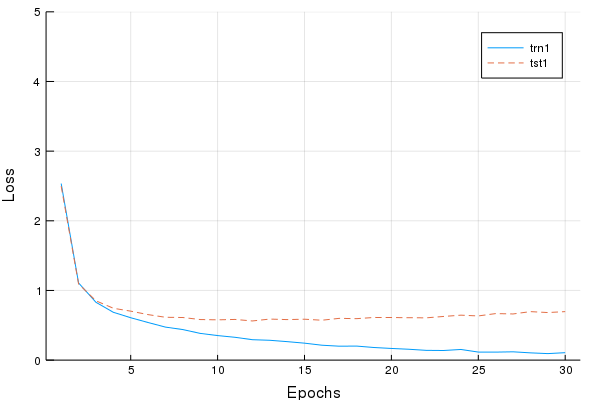

In [58]:
plot([r12[1,:], r12[2,:]], ylim=(0.0,5.0),
    labels=[:trn1 :tst1],xlabel="Epochs",ylabel="Loss")

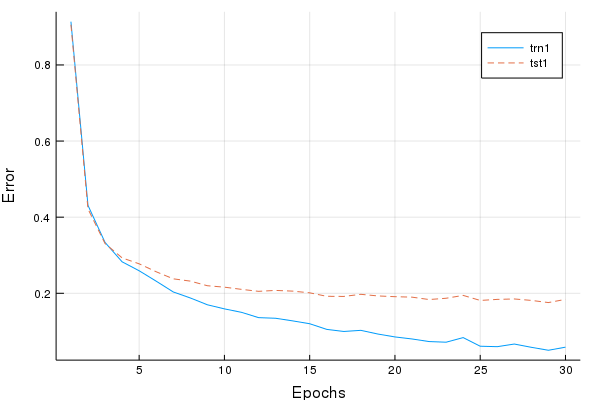

In [59]:
plot([r12[3,:], r12[4,:]], ylim=(0.0,1,0),
    labels=[:trn1 :tst1],xlabel="Epochs",ylabel="Error")

In [60]:
mymodel6t()

MethodError: MethodError: no method matching (::Chain)()
Closest candidates are:
  Chain(!Matched::Data) at In[36]:7
  Chain(!Matched::Any) at In[36]:5
  Chain(!Matched::Any, !Matched::MyData1) at In[36]:9
  ...

In [61]:
datmb2[1][1]

25×53 Array{Int64,2}:
 399999    201      5    158  …     426      48     425       3
 399999      1   3785     58       3752     341       3       9
 399999  55527      2      6          1    1417   10979       3
 399999      7      8    225          5    4828    4767       3
 399999     50      1   8247       5614     806      58       9
 399999     64     15      8  …    4290     330       9       3
 399999     14      1     69        763       7     133       3
 399999     30    200    442     129422       9      25       3
 399999  19998    393   1202        500     536    3268       3
 399999  19998    393   1202        500     536    3268       3
 399999    583     76   5347  …       1  400000      25       3
 399999     53      2     82          1  221649     694       3
 399999     53      2     82          1  221649     694       3
 399999      7      1   1653        875       4     546       3
 399999     23     59     40          5     490     509       3
 399999     50    

In [62]:
print(timo)

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      70.1s / 0.00%           5.91GiB / 0.00%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 ──────────────────────────────────────────────────────────────────

In [63]:
Knet.reset_timer!(timo)

 ──────────────────────────────────────────────────────────────────
                           Time                   Allocations      
                   ──────────────────────   ───────────────────────
 Tot / % measured:      116μs / 0.00%           2.84KiB / 0.00%    

 Section   ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────
 ──────────────────────────────────────────────────────────────────

In [64]:
@doc Knet.load

```
Knet.load(filename, args...; kwargs...)
```

Call `FileIO.load` then deserialize Knet specific values.

File format is determined by FileIO. JLD and JLD2 are supported. Other formats may work if supported by FileIO, please refer to the documentation of FileIO and the specific format. Example:

```
Knet.load("foo.jld2")           # returns a ("name"=>value) dictionary
Knet.load("foo.jld2", "name1")  # returns the value of "name1" in "foo.jld2"
Knet.load("foo.jld2", "name1", "name2")   # returns tuple (value1, value2)
```


In [65]:
asdasin(x) = reshape(cat(rootind,map(getind,x), dims=1),1,length(x)+1)

asdasin (generic function with 1 method)

In [72]:
println("Enter a sentence to be parsed: ")
sentence = readline()
result = mymodel6t(asdasin(take_input(sentence)))

Enter a sentence to be parsed: 
stdin> We worked really hard for this project.


9×8×1 KnetArray{Float32,3}:
[:, :, 1] =
 -11.6602     6.36636   -21.6359    …  -13.8338   -14.8665 
  -6.20239   -8.96421   -16.2589       -13.9588    -7.71908
   7.02403   -0.713257   -2.48703        2.05475    6.47885
  -9.79687   -7.93826   -15.4541        -9.24319   -9.88676
   5.0923     2.28437    -0.473339       2.04416    4.55636
 -24.5204   -14.5041    -33.0957    …  -20.1365   -23.1007 
 -23.9654   -12.4468    -29.0731       -16.7158   -21.2377 
 -12.2982    -6.68572   -23.8598        -8.60032   -8.92816
 -31.2221   -22.4409    -39.3125       -27.2376   -29.4264 

In [69]:
@doc Knet.load

```
Knet.load(filename, args...; kwargs...)
```

Call `FileIO.load` then deserialize Knet specific values.

File format is determined by FileIO. JLD and JLD2 are supported. Other formats may work if supported by FileIO, please refer to the documentation of FileIO and the specific format. Example:

```
Knet.load("foo.jld2")           # returns a ("name"=>value) dictionary
Knet.load("foo.jld2", "name1")  # returns the value of "name1" in "foo.jld2"
Knet.load("foo.jld2", "name1", "name2")   # returns tuple (value1, value2)
```


In [70]:
mymodel6t = Knet.load("mymodel6t21err1_19err_1.jld2","model16t_19err")

Chain((Embed(P(KnetArray{Float32,2}(50,400000))), LSTM(input=50,hidden=150,bidirectional,dropout=0.3), Biaff(Chain((Dense(P(KnetArray{Float32,2}(75,300)), P(KnetArray{Float32,1}(75)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,75)), P(KnetArray{Float32,1}(50)), Knet.relu))), Chain((Dense(P(KnetArray{Float32,2}(75,300)), P(KnetArray{Float32,1}(75)), Knet.relu), Dense(P(KnetArray{Float32,2}(50,75)), P(KnetArray{Float32,1}(50)), Knet.relu))), P(KnetArray{Float32,2}(50,50)), P(KnetArray{Float32,1}(50)))))